This notebook uses motifbreakR to exam motifs disrupted by caQTL snps. The first step is to get a list of snps in the right format for motifbreakR. Second is to run motifbreakR, and then third is to run testing to see what motifs are more disrupted in caQTLs.

For the PBMC project Paola only tested SNPs within the peak itself. For the islet multiome project we tested SNPs within peaks within 10kb of the peak we are testing. This means our lead variant isn't necessarily within the peak itself, which makes running motifbreakR less clear here. Paola suggested three tests:
1) All leads regardless of being in the peak. This seems less biologically correct.  
2) All of the current set of leads within their peak. This seems good, though we may miss signal.  
3) Create a new set of leads using only SNPs within peaks. This seems good, but not sure how this integrates with FDR.  

We are using any lead in a peak

In [1]:
suppressPackageStartupMessages(library(motifbreakR))
suppressPackageStartupMessages(library(MotifDb))
suppressPackageStartupMessages(library(BSgenome))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library("BSgenome.Hsapiens.UCSC.hg38"))
suppressPackageStartupMessages(library(motifStack))
suppressPackageStartupMessages(library(data.table))
library(stringr)
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(gridExtra))
suppressPackageStartupMessages(library(ggplot2))
#library(MotIV) ###(only with older versions on R (in gatsby) )
library(scales)
library(vroom)
library(parallel)

See system.file("LICENSE", package="MotifDb") for use restrictions.


Attaching package: 'vroom'


The following object is masked from 'package:scales':

    col_factor




In [2]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.2 LTS

Matrix products: default
BLAS/LAPACK: /home/welison/.conda/envs/mamba/envs/motifbreakR/lib/libopenblasp-r0.3.27.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/Los_Angeles
tzcode source: system (glibc)

attached base packages:
 [1] parallel  stats4    grid      stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] vroom_1.6.5                       scales_1.3.0                     
 [3] ggplot2_3.5.1                     gridExtra_2.3                    
 [5] RColorBrewer_1.1-3

In [2]:
setwd('/path/to/caQTL/stuff/motifs')

In [3]:
leadvars = read.table('../caQTLs_rasqual/Summary_allCells_leads_run1F.tsv', header=T)

In [4]:
dim(leadvars)
head(leadvars)

[1] 773267     34

,Feature,rsID,Chromosome,position,Ref,Alt,Af,HWEChi_square,IA,Log10_qval,⋯,r2_rSNP,P_VAl,dist,flag_fdr10,flag_fdr05,flag_fdr01,cell,exclude,qtl,feature_snp
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<int>,<lgl>,<lgl>,<lgl>,<chr>,<lgl>,<lgl>,<chr>
1,chr6:32622377-32623439,chr6:32620608:T:A,chr6,32620608,T,A,0.425926,2.231991,0.998678,-67.03611,⋯,0.824496,8.976233e-71,-2300,TRUE,TRUE,TRUE,acinar,FALSE,TRUE,chr6:32622377-32623439_chr6:32620608:T:A
2,chr9:6931452-6932441,chr9:6929401:T:A,chr9,6929401,T,A,0.333333,0.750000,0.993936,-36.60879,⋯,0.985795,1.925609e-38,-2545,TRUE,TRUE,TRUE,acinar,FALSE,TRUE,chr9:6931452-6932441_chr9:6929401:T:A
3,chr4:7164816-7165698,chr4:7160692:T:C,chr4,7160692,T,C,0.277778,0.006391,0.999935,-32.46831,⋯,0.902371,1.502522e-34,-4565,TRUE,TRUE,TRUE,acinar,FALSE,TRUE,chr4:7164816-7165698_chr4:7160692:T:C
4,chr9:93230239-93231938,chr9:93231475:G:A,chr9,93231475,G,A,0.222222,0.137755,0.999392,-30.83427,⋯,0.992117,3.105136e-32,387,TRUE,TRUE,TRUE,acinar,FALSE,TRUE,chr9:93230239-93231938_chr9:93231475:G:A
5,chr17:76968760-76970675,chr17:76972946:C:A,chr17,76972946,C,A,0.296296,0.337734,0.980182,-29.73370,⋯,0.940828,4.969777e-32,3228,TRUE,TRUE,TRUE,acinar,FALSE,TRUE,chr17:76968760-76970675_chr17:76972946:C:A
6,chr21:13979625-13980808,chr21:13980560:G:C,chr21,13980560,G,C,0.314815,0.083599,0.930667,-27.70426,⋯,0.870565,7.793799e-30,344,TRUE,TRUE,TRUE,acinar,FALSE,TRUE,chr21:13979625-13980808_chr21:13980560:G:C


### 2 Leads within peaks RUNNING THIS ONE

In [11]:
dim(leadvars) #Run4 513256x34
head(leadvars)

[1] 773267     34

,Feature,rsID,Chromosome,position,Ref,Alt,Af,HWEChi_square,IA,Log10_qval,⋯,r2_rSNP,P_VAl,dist,flag_fdr10,flag_fdr05,flag_fdr01,cell,exclude,qtl,feature_snp
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<int>,<lgl>,<lgl>,<lgl>,<chr>,<lgl>,<lgl>,<chr>
1,chr6:32622377-32623439,chr6:32620608:T:A,chr6,32620608,T,A,0.425926,2.231991,0.998678,-67.03611,⋯,0.824496,8.976233e-71,-2300,TRUE,TRUE,TRUE,acinar,FALSE,TRUE,chr6:32622377-32623439_chr6:32620608:T:A
2,chr9:6931452-6932441,chr9:6929401:T:A,chr9,6929401,T,A,0.333333,0.750000,0.993936,-36.60879,⋯,0.985795,1.925609e-38,-2545,TRUE,TRUE,TRUE,acinar,FALSE,TRUE,chr9:6931452-6932441_chr9:6929401:T:A
3,chr4:7164816-7165698,chr4:7160692:T:C,chr4,7160692,T,C,0.277778,0.006391,0.999935,-32.46831,⋯,0.902371,1.502522e-34,-4565,TRUE,TRUE,TRUE,acinar,FALSE,TRUE,chr4:7164816-7165698_chr4:7160692:T:C
4,chr9:93230239-93231938,chr9:93231475:G:A,chr9,93231475,G,A,0.222222,0.137755,0.999392,-30.83427,⋯,0.992117,3.105136e-32,387,TRUE,TRUE,TRUE,acinar,FALSE,TRUE,chr9:93230239-93231938_chr9:93231475:G:A
5,chr17:76968760-76970675,chr17:76972946:C:A,chr17,76972946,C,A,0.296296,0.337734,0.980182,-29.73370,⋯,0.940828,4.969777e-32,3228,TRUE,TRUE,TRUE,acinar,FALSE,TRUE,chr17:76968760-76970675_chr17:76972946:C:A
6,chr21:13979625-13980808,chr21:13980560:G:C,chr21,13980560,G,C,0.314815,0.083599,0.930667,-27.70426,⋯,0.870565,7.793799e-30,344,TRUE,TRUE,TRUE,acinar,FALSE,TRUE,chr21:13979625-13980808_chr21:13980560:G:C


In [12]:
peak_positions <- str_split(str_split(leadvars$Feature, ":", simplify=T)[,2], "-", simplify=T)
dim(peak_positions)
head(peak_positions)

leadvars$start <- peak_positions[,1]
leadvars$end <- peak_positions[,2]

dim(leadvars) #Run4: 513256x36
head(leadvars)

[1] 773267      2

32622377,32623439
6931452,6932441
7164816,7165698
93230239,93231938
76968760,76970675
13979625,13980808


[1] 773267     36

,Feature,rsID,Chromosome,position,Ref,Alt,Af,HWEChi_square,IA,Log10_qval,⋯,dist,flag_fdr10,flag_fdr05,flag_fdr01,cell,exclude,qtl,feature_snp,start,end
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<lgl>,<lgl>,<lgl>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<chr>
1,chr6:32622377-32623439,chr6:32620608:T:A,chr6,32620608,T,A,0.425926,2.231991,0.998678,-67.03611,⋯,-2300,TRUE,TRUE,TRUE,acinar,FALSE,TRUE,chr6:32622377-32623439_chr6:32620608:T:A,32622377,32623439
2,chr9:6931452-6932441,chr9:6929401:T:A,chr9,6929401,T,A,0.333333,0.750000,0.993936,-36.60879,⋯,-2545,TRUE,TRUE,TRUE,acinar,FALSE,TRUE,chr9:6931452-6932441_chr9:6929401:T:A,6931452,6932441
3,chr4:7164816-7165698,chr4:7160692:T:C,chr4,7160692,T,C,0.277778,0.006391,0.999935,-32.46831,⋯,-4565,TRUE,TRUE,TRUE,acinar,FALSE,TRUE,chr4:7164816-7165698_chr4:7160692:T:C,7164816,7165698
4,chr9:93230239-93231938,chr9:93231475:G:A,chr9,93231475,G,A,0.222222,0.137755,0.999392,-30.83427,⋯,387,TRUE,TRUE,TRUE,acinar,FALSE,TRUE,chr9:93230239-93231938_chr9:93231475:G:A,93230239,93231938
5,chr17:76968760-76970675,chr17:76972946:C:A,chr17,76972946,C,A,0.296296,0.337734,0.980182,-29.73370,⋯,3228,TRUE,TRUE,TRUE,acinar,FALSE,TRUE,chr17:76968760-76970675_chr17:76972946:C:A,76968760,76970675
6,chr21:13979625-13980808,chr21:13980560:G:C,chr21,13980560,G,C,0.314815,0.083599,0.930667,-27.70426,⋯,344,TRUE,TRUE,TRUE,acinar,FALSE,TRUE,chr21:13979625-13980808_chr21:13980560:G:C,13979625,13980808


In [13]:
leadvars$in_peak <- (leadvars$position > leadvars$start) & (leadvars$position < leadvars$end)
leadvars_filt_peak <- leadvars[leadvars$in_peak,]

dim(leadvars_filt_peak) #Run4 56890x37
head(leadvars_filt_peak)

[1] 77659    37

,Feature,rsID,Chromosome,position,Ref,Alt,Af,HWEChi_square,IA,Log10_qval,⋯,flag_fdr10,flag_fdr05,flag_fdr01,cell,exclude,qtl,feature_snp,start,end,in_peak
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<lgl>,<lgl>,<lgl>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<chr>,<lgl>
4,chr9:93230239-93231938,chr9:93231475:G:A,chr9,93231475,G,A,0.222222,0.137755,0.999392,-30.83427,⋯,TRUE,TRUE,TRUE,acinar,FALSE,TRUE,chr9:93230239-93231938_chr9:93231475:G:A,93230239,93231938,TRUE
6,chr21:13979625-13980808,chr21:13980560:G:C,chr21,13980560,G,C,0.314815,0.083599,0.930667,-27.70426,⋯,TRUE,TRUE,TRUE,acinar,FALSE,TRUE,chr21:13979625-13980808_chr21:13980560:G:C,13979625,13980808,TRUE
8,chr8:17607871-17609288,chr8:17608416:A:G,chr8,17608416,A,G,0.203704,0.020395,0.999237,-26.74354,⋯,TRUE,TRUE,TRUE,acinar,FALSE,TRUE,chr8:17607871-17609288_chr8:17608416:A:G,17607871,17609288,TRUE
10,chr3:125990029-125991054,chr3:125990207:G:T,chr3,125990207,G,T,0.185185,0.008926,0.999056,-26.18753,⋯,TRUE,TRUE,TRUE,acinar,FALSE,TRUE,chr3:125990029-125991054_chr3:125990207:G:T,125990029,125991054,TRUE
11,chr18:8799900-8801529,chr18:8800393:A:T,chr18,8800393,A,T,0.092593,0.281133,0.998518,-24.17044,⋯,TRUE,TRUE,TRUE,acinar,FALSE,TRUE,chr18:8799900-8801529_chr18:8800393:A:T,8799900,8801529,TRUE
12,chr1:18480265-18481643,chr1:18480845:T:C,chr1,18480845,T,C,0.555556,0.067500,0.980277,-23.66970,⋯,TRUE,TRUE,TRUE,acinar,FALSE,TRUE,chr1:18480265-18481643_chr1:18480845:T:C,18480265,18481643,TRUE


In [14]:
sum(leadvars_filt_peak$flag_fdr05) #Run4 4978

[1] 10861

In [15]:
spt_filt_peak = str_split_fixed(leadvars_filt_peak$rsID, "\\:", 4)
newinps_filt_peak = data.frame(spt_filt_peak[,1], as.numeric(spt_filt_peak[,2])-1, spt_filt_peak[,2], leadvars_filt_peak$rsID, 0, "+" )
newinps_filt_peak = newinps_filt_peak[!duplicated(newinps_filt_peak),]
dim(newinps_filt_peak) #Run4: 44740x6

[1] 57023     6

In [16]:
options(scipen=10)
write.table(newinps_filt_peak, "Input_leadvars_list_all_leads_filt_to_peaks_Run1F.tsv", sep="\t", quote=F, row.names=F, col.names=F, )
options(scipen=0)

In [17]:
snps <- snps.from.file(file = "Input_leadvars_list_all_leads_filt_to_peaks_Run1F.tsv",search.genome = BSgenome.Hsapiens.UCSC.hg38,format = "bed")                                 
snps

GRanges object with 57023 ranges and 3 metadata columns:
                     seqnames    ranges strand |             SNP_id
                        <Rle> <IRanges>  <Rle> |        <character>
   chr9:93231475:G:A     chr9  93231475      * |  chr9:93231475:G:A
  chr21:13980560:G:C    chr21  13980560      * | chr21:13980560:G:C
   chr8:17608416:A:G     chr8  17608416      * |  chr8:17608416:A:G
  chr3:125990207:G:T     chr3 125990207      * | chr3:125990207:G:T
   chr18:8800393:A:T    chr18   8800393      * |  chr18:8800393:A:T
                 ...      ...       ...    ... .                ...
  chr4:109484529:A:G     chr4 109484529      * | chr4:109484529:A:G
  chr17:64694595:C:G    chr17  64694595      * | chr17:64694595:C:G
   chr9:15454007:A:G     chr9  15454007      * |  chr9:15454007:A:G
   chr8:80742864:C:T     chr8  80742864      * |  chr8:80742864:C:T
  chr3:167684656:A:C     chr3 167684656      * | chr3:167684656:A:C
                                REF            ALT
        

##### Run motifbreakR

In [18]:
hocomoco2 = MotifDb[mcols(MotifDb)$dataSource=='HOCOMOCOv10' & mcols(MotifDb)$organism=='Hsapiens']
jaspar = MotifDb[mcols(MotifDb)$dataSource=='jaspar2022' & mcols(MotifDb)$organism=='Hsapiens']

snps <- snps.from.file(file = "Input_leadvars_list_all_leads_filt_to_peaks_Run1F.tsv",search.genome = BSgenome.Hsapiens.UCSC.hg38,format = "bed")                                 
n = length(snps)
s =seq(1, n, by=200)
end = s[length(s)-1]
e =c(seq(200, n, by=200),n)

In [20]:
for (i in seq(1:length(s))){
    test=snps[s[i]:e[i]]
    results <- mclapply(1:length(test), function(x) data.frame(motifbreakR(snpList = test[x], filterp = TRUE,
                       pwmList = hocomoco2,
                       method="ic",
                       threshold = 5e-4,
                       BPPARAM = BiocParallel::bpparam("SerialParam"))), mc.cores=18 )
                        
    results2 <- mclapply(1:length(test), function(x) data.frame(motifbreakR(snpList = test[x], filterp = TRUE,
                       pwmList = jaspar,
                       method="ic",
                       threshold = 5e-4,
                       BPPARAM = BiocParallel::bpparam("SerialParam"))), mc.cores=18 )

    rb2 = rbindlist(results2[lapply(results, class) == "data.frame"])
    rb = rbindlist(results[lapply(results, class) == "data.frame"])
                         
    rb$motifPos2 <- sapply(rb$motifPos,"[[",2)
    rb$motifPos <- sapply(rb$motifPos,"[[",1)
                         
    rb2$motifPos2 <- sapply(rb2$motifPos,"[[",2)
    rb2$motifPos <- sapply(rb2$motifPos,"[[",1)

    if(nrow(rb)>0){
      write.table(rb2,  paste0("jaspar/filtered_leads_Run1F/Results_JASPAR2022_", s[i], "_", e[i], ".tsv"), quote=F, row.names=F, sep="\t")  
      write.table(rb, paste0("hocomoco/filtered_leads_Run1F/Results_Hocomoco_", s[i], "_", e[i], ".tsv"), quote=F, row.names=F, sep="\t")  
    }
    message(paste0(i, " out of ", length(s)))
                        
    gc()
}   

1 out of 286

2 out of 286

3 out of 286

4 out of 286

5 out of 286

6 out of 286

7 out of 286

8 out of 286

9 out of 286

10 out of 286

11 out of 286

12 out of 286

13 out of 286

14 out of 286

15 out of 286

16 out of 286

17 out of 286

18 out of 286

19 out of 286

20 out of 286

21 out of 286

22 out of 286

23 out of 286

24 out of 286

25 out of 286

26 out of 286

27 out of 286

28 out of 286

29 out of 286

30 out of 286

31 out of 286

32 out of 286

33 out of 286

34 out of 286

35 out of 286

36 out of 286

37 out of 286

38 out of 286

39 out of 286

40 out of 286

41 out of 286

42 out of 286

43 out of 286

44 out of 286

45 out of 286

46 out of 286

47 out of 286

48 out of 286

49 out of 286

50 out of 286

51 out of 286

52 out of 286

53 out of 286

54 out of 286

55 out of 286

56 out of 286

57 out of 286

58 out of 286

59 out of 286

60 out of 286

61 out of 286

62 out of 286

63 out of 286

64 out of 286

65 out of 286

66 out of 286

67 out of 286

68 o

In [ ]:
getwd()

### Compile results

In [22]:
files = list.files('jaspar/filtered_leads_Run1F')[grepl("Results_JASPAR2022", list.files('jaspar/filtered_leads_Run1F'))]

In [23]:
length(files)

[1] 286

In [105]:
head(RES)

,seqnames,start,end,width,strand,SNP_id,REF,ALT,varType,motifPos,⋯,Refpvalue,Altpvalue,snpPos,alleleRef,alleleAlt,effect,altPos,alleleDiff,alleleEffectSize,motifPos2
,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<int>,<dbl>,<dbl>,<int>
1,chr9,93231475,93231475,1,+,chr9:93231475:G:A,G,A,SNV,-14,⋯,NA,NA,NA,NA,NA,strong,1,1.995541,0.11599371,2
2,chr9,93231475,93231475,1,-,chr9:93231475:G:A,G,A,SNV,-6,⋯,NA,NA,NA,NA,NA,strong,1,1.699536,0.15522056,5
3,chr9,93231475,93231475,1,+,chr9:93231475:G:A,G,A,SNV,-7,⋯,NA,NA,NA,NA,NA,strong,1,1.768648,0.14276160,4
4,chr9,93231475,93231475,1,+,chr9:93231475:G:A,G,A,SNV,-13,⋯,NA,NA,NA,NA,NA,strong,1,1.838902,0.13884251,1
5,chr9,93231475,93231475,1,+,chr9:93231475:G:A,G,A,SNV,-6,⋯,NA,NA,NA,NA,NA,strong,1,1.463975,0.20923253,2
6,chr9,93231475,93231475,1,-,chr9:93231475:G:A,G,A,SNV,-16,⋯,NA,NA,NA,NA,NA,strong,1,1.316830,0.07888577,4


In [40]:
RES = data.frame()
for( f in files){
    res = read.table(paste0('jaspar/filtered_leads_Run1F/',f),  row.names=NULL, header=T, sep="\t", stringsAsFactors = F)
    RES = rbind(RES, res)
}

tab = RES[, c(6,10:21, 26,27,25)]
tab = tab[order(-abs(tab$alleleDiff)),]
tab = tab[!duplicated(tab[,c('SNP_id','geneSymbol' )]),]

dim(tab) #Run4 381113x16

write.table(tab, "Summary_significant_motifs_JASPAR2022_inpeaks_filtered_leads_Run1F.tsv", sep="\t", row.names=F, quote=F)

strong = subset(tab,effect=="strong" )

[1] 571316     16

In [41]:
RES[,9:15]

varType,motifPos,geneSymbol,dataSource,providerName,providerId,seqMatch
<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
SNV,-14,NFIC,jaspar2022,MA1527.1,MA1527.1,aggtgggctgggtgccAatgctcgtggtgtgtg
SNV,-6,NFYB,jaspar2022,MA0502.2,MA0502.2,ggctgggtgccAatgctcgtggt
SNV,-7,MGA::EVX1,jaspar2022,MA1960.1,MA1960.1,ggctgggtgccAatgctcgtggt
SNV,-13,ZNF417,jaspar2022,MA1727.1,MA1727.1,gtgggctgggtgccAatgctcgtggtgtg
SNV,-6,NFIX,jaspar2022,MA0671.1,MA0671.1,tgggtgccAatgctcgt
SNV,-16,NFIB,jaspar2022,MA1643.1,MA1643.1,ggggaggtgggctgggtgccAatgctcgtggtgtgtgtggg
SNV,-11,ZNF16,jaspar2022,MA1654.1,MA1654.1,aggggaggtgggctgggtgccAatgctcgtggtgtgtgtgggca
SNV,-14,NFIX,jaspar2022,MA1528.1,MA1528.1,aggtgggctgggtgccAatgctcgtggtgtgtg
SNV,-6,NFIC,jaspar2022,MA0161.2,MA0161.2,gctgggtgccAatgctcgtgg


In [42]:
dim(RES) #Run4 388681x24
head(RES)

[1] 576212     29

,seqnames,start,end,width,strand,SNP_id,REF,ALT,varType,motifPos,⋯,Refpvalue,Altpvalue,snpPos,alleleRef,alleleAlt,effect,altPos,alleleDiff,alleleEffectSize,motifPos2
,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<int>,<dbl>,<dbl>,<int>
1,chr9,93231475,93231475,1,+,chr9:93231475:G:A,G,A,SNV,-14,⋯,NA,NA,NA,NA,NA,strong,1,1.995541,0.11599371,2
2,chr9,93231475,93231475,1,-,chr9:93231475:G:A,G,A,SNV,-6,⋯,NA,NA,NA,NA,NA,strong,1,1.699536,0.15522056,5
3,chr9,93231475,93231475,1,+,chr9:93231475:G:A,G,A,SNV,-7,⋯,NA,NA,NA,NA,NA,strong,1,1.768648,0.14276160,4
4,chr9,93231475,93231475,1,+,chr9:93231475:G:A,G,A,SNV,-13,⋯,NA,NA,NA,NA,NA,strong,1,1.838902,0.13884251,1
5,chr9,93231475,93231475,1,+,chr9:93231475:G:A,G,A,SNV,-6,⋯,NA,NA,NA,NA,NA,strong,1,1.463975,0.20923253,2
6,chr9,93231475,93231475,1,-,chr9:93231475:G:A,G,A,SNV,-16,⋯,NA,NA,NA,NA,NA,strong,1,1.316830,0.07888577,4


In [43]:
dim(strong) #Run4 298829x16

[1] 502805     16

In [44]:
write.table(strong, "Summary_significant_motifs_JASPAR2022_strong_inpeaks_filtered_leads_Run1F.tsv", sep="\t", row.names=F, quote=F)

# Enrichment Test

We got a little lost on all this enrichment testing, I am going to remake the cell type test

In [113]:
motifs <- read.table("/path/to/caQTL/stuff/motifs/Summary_significant_motifs_JASPAR2022_inpeaks_filtered_leads_Run1F.tsv", sep="\t", header=T)
dim(motifs)
head(motifs)

[1] 571316     16

,SNP_id,motifPos,geneSymbol,dataSource,providerName,providerId,seqMatch,pctRef,pctAlt,scoreRef,scoreAlt,Refpvalue,Altpvalue,altPos,alleleDiff,effect
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<int>,<dbl>,<chr>
1,chr5:177481730:A:C,-1,TCFL5,jaspar2022,MA0632.2,MA0632.2,gtgtgagtcCccgtgccca,0.6833266,0.8748082,7.228160,9.228051,NA,NA,1,1.999892,strong
2,chr11:64271703:G:A,-8,TCFL5,jaspar2022,MA0632.2,MA0632.2,cgagcgcgaGcggccccga,0.9447054,0.7532239,9.958080,7.958188,NA,NA,1,-1.999892,strong
3,chr22:38927250:G:A,-8,TCFL5,jaspar2022,MA0632.2,MA0632.2,gtggcgcgaGcctggtgcc,0.9204063,0.7289248,9.704292,7.704401,NA,NA,1,-1.999892,strong
4,chr2:26562410:G:C,-8,TCFL5,jaspar2022,MA0632.2,MA0632.2,agagctcgcGgaaatggga,0.8733464,0.6818648,9.212784,7.212892,NA,NA,1,-1.999892,strong
5,chr18:31101232:C:G,-8,TCFL5,jaspar2022,MA0632.2,MA0632.2,agggctcgcGggtcgacag,0.6838573,0.8753389,7.233703,9.233594,NA,NA,1,1.999892,strong
6,chr7:31028566:G:A,-8,TCFL5,jaspar2022,MA0632.2,MA0632.2,tcggcgcggGaggcagggc,0.9182012,0.7267196,9.681261,7.681369,NA,NA,1,-1.999892,strong


In [114]:
strong <- read.table("/path/to/caQTL/stuff/motifs/Summary_significant_motifs_JASPAR2022_strong_inpeaks_filtered_leads_Run1F.tsv", sep="\t", header=T)
dim(strong)
head(strong)

[1] 502805     16

,SNP_id,motifPos,geneSymbol,dataSource,providerName,providerId,seqMatch,pctRef,pctAlt,scoreRef,scoreAlt,Refpvalue,Altpvalue,altPos,alleleDiff,effect
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<int>,<dbl>,<chr>
1,chr5:177481730:A:C,-1,TCFL5,jaspar2022,MA0632.2,MA0632.2,gtgtgagtcCccgtgccca,0.6833266,0.8748082,7.228160,9.228051,NA,NA,1,1.999892,strong
2,chr11:64271703:G:A,-8,TCFL5,jaspar2022,MA0632.2,MA0632.2,cgagcgcgaGcggccccga,0.9447054,0.7532239,9.958080,7.958188,NA,NA,1,-1.999892,strong
3,chr22:38927250:G:A,-8,TCFL5,jaspar2022,MA0632.2,MA0632.2,gtggcgcgaGcctggtgcc,0.9204063,0.7289248,9.704292,7.704401,NA,NA,1,-1.999892,strong
4,chr2:26562410:G:C,-8,TCFL5,jaspar2022,MA0632.2,MA0632.2,agagctcgcGgaaatggga,0.8733464,0.6818648,9.212784,7.212892,NA,NA,1,-1.999892,strong
5,chr18:31101232:C:G,-8,TCFL5,jaspar2022,MA0632.2,MA0632.2,agggctcgcGggtcgacag,0.6838573,0.8753389,7.233703,9.233594,NA,NA,1,1.999892,strong
6,chr7:31028566:G:A,-8,TCFL5,jaspar2022,MA0632.2,MA0632.2,tcggcgcggGaggcagggc,0.9182012,0.7267196,9.681261,7.681369,NA,NA,1,-1.999892,strong


In [148]:
leadvars = vroom('../caQTLs_rasqual/Summary_allCells_leads_run1F.tsv')

dim(leadvars)
head(leadvars)

Rows: 773267 Columns: 34
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (7): Feature, rsID, Chromosome, Ref, Alt, cell, feature_snp
dbl (22): position, Af, HWEChi_square, IA, Log10_qval, Chi_square, Effect_si...
lgl  (5): flag_fdr10, flag_fdr05, flag_fdr01, exclude, qtl

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 773267     34

Feature,rsID,Chromosome,position,Ref,Alt,Af,HWEChi_square,IA,Log10_qval,⋯,r2_rSNP,P_VAl,dist,flag_fdr10,flag_fdr05,flag_fdr01,cell,exclude,qtl,feature_snp
<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<chr>,<lgl>,<lgl>,<chr>
chr6:32622377-32623439,chr6:32620608:T:A,chr6,32620608,T,A,0.425926,2.231991,0.998678,-67.03611,⋯,0.824496,8.976233e-71,-2300,TRUE,TRUE,TRUE,acinar,FALSE,TRUE,chr6:32622377-32623439_chr6:32620608:T:A
chr9:6931452-6932441,chr9:6929401:T:A,chr9,6929401,T,A,0.333333,0.750000,0.993936,-36.60879,⋯,0.985795,1.925609e-38,-2545,TRUE,TRUE,TRUE,acinar,FALSE,TRUE,chr9:6931452-6932441_chr9:6929401:T:A
chr4:7164816-7165698,chr4:7160692:T:C,chr4,7160692,T,C,0.277778,0.006391,0.999935,-32.46831,⋯,0.902371,1.502522e-34,-4565,TRUE,TRUE,TRUE,acinar,FALSE,TRUE,chr4:7164816-7165698_chr4:7160692:T:C
chr9:93230239-93231938,chr9:93231475:G:A,chr9,93231475,G,A,0.222222,0.137755,0.999392,-30.83427,⋯,0.992117,3.105136e-32,387,TRUE,TRUE,TRUE,acinar,FALSE,TRUE,chr9:93230239-93231938_chr9:93231475:G:A
chr17:76968760-76970675,chr17:76972946:C:A,chr17,76972946,C,A,0.296296,0.337734,0.980182,-29.73370,⋯,0.940828,4.969777e-32,3228,TRUE,TRUE,TRUE,acinar,FALSE,TRUE,chr17:76968760-76970675_chr17:76972946:C:A
chr21:13979625-13980808,chr21:13980560:G:C,chr21,13980560,G,C,0.314815,0.083599,0.930667,-27.70426,⋯,0.870565,7.793799e-30,344,TRUE,TRUE,TRUE,acinar,FALSE,TRUE,chr21:13979625-13980808_chr21:13980560:G:C


In [189]:
motifs$disrupted <- TRUE
motifs_wide <- select(motifs, SNP_id, geneSymbol, disrupted) %>%
    group_by(SNP_id) %>%
    pivot_wider(names_from=geneSymbol, values_from=disrupted, values_fill=FALSE)

full.res <- data.frame()

for (c in c('beta','alpha','acinar', 'ductal', 'delta','gamma')) {
    ct_lead <- filter(leadvars, cell == c)
    ct_lead_motif <- left_join(ct_lead, motifs_wide, join_by(rsID==SNP_id))
    ct_lead_motif <- filter(ct_lead_motif, !is.na(ISL2))
    
    ct.res <- data.frame()
    for (test.motif in colnames(motifs_wide)[2:ncol(motifs_wide)]) {
        test.res <- broom::tidy(fisher.test(table(ct_lead_motif[c('flag_fdr05', test.motif)])))
        test.res$cell <- c
        test.res$motif <- test.motif
        ct.res <- rbind(ct.res, test.res)
    }
    
    ct.res[ct.res$p.value > 1,]$p.value <- 1
    ct.res[ct.res$p.value < 0,]$p.value <- 0
    ct.res$q.value <- qvalue(ct.res$p.value)$qvalues
    ct.res <- arrange(ct.res, q.value)
    
    full.res <- rbind(full.res, ct.res)
}

dim(full.res)
head(full.res)

[1] 3870    9

estimate,p.value,conf.low,conf.high,method,alternative,cell,motif,q.value
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
4.420757,8.699078e-43,3.592280,5.436096,Fisher's Exact Test for Count Data,two.sided,beta,FOS::JUND,4.557432e-40
4.510413,1.753994e-40,3.631527,5.597729,Fisher's Exact Test for Count Data,two.sided,beta,BNC2,4.594571e-38
4.249562,2.637712e-39,3.441052,5.243268,Fisher's Exact Test for Count Data,two.sided,beta,FOSL2,4.606310e-37
4.462689,5.584965e-39,3.582619,5.554631,Fisher's Exact Test for Count Data,two.sided,beta,FOS::JUNB,7.233218e-37
4.115597,6.903266e-39,3.344780,5.058217,Fisher's Exact Test for Count Data,two.sided,beta,FOSL1,7.233218e-37
4.183061,4.772672e-37,3.372821,5.182458,Fisher's Exact Test for Count Data,two.sided,beta,BATF,4.167324e-35


In [190]:
table(full.res$cell, full.res$q.value < 0.05)

        
         FALSE TRUE
  acinar   598   47
  alpha    593   52
  beta     573   72
  delta    618   27
  ductal   645    0
  gamma    618   27

In [191]:
filter(full.res, cell=='beta' & q.value < 0.05)

estimate,p.value,conf.low,conf.high,method,alternative,cell,motif,q.value
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
4.420757,8.699078e-43,3.592280,5.436096,Fisher's Exact Test for Count Data,two.sided,beta,FOS::JUND,4.557432e-40
4.510413,1.753994e-40,3.631527,5.597729,Fisher's Exact Test for Count Data,two.sided,beta,BNC2,4.594571e-38
4.249562,2.637712e-39,3.441052,5.243268,Fisher's Exact Test for Count Data,two.sided,beta,FOSL2,4.606310e-37
4.462689,5.584965e-39,3.582619,5.554631,Fisher's Exact Test for Count Data,two.sided,beta,FOS::JUNB,7.233218e-37
4.115597,6.903266e-39,3.344780,5.058217,Fisher's Exact Test for Count Data,two.sided,beta,FOSL1,7.233218e-37
4.183061,4.772672e-37,3.372821,5.182458,Fisher's Exact Test for Count Data,two.sided,beta,BATF,4.167324e-35
4.113602,7.672411e-37,3.323359,5.085960,Fisher's Exact Test for Count Data,two.sided,beta,BATF::JUN,5.742232e-35
4.426683,4.763535e-36,3.525078,5.554450,Fisher's Exact Test for Count Data,two.sided,beta,FOSL1::JUNB,3.119510e-34
3.914248,8.883311e-36,3.176638,4.816649,Fisher's Exact Test for Count Data,two.sided,beta,NFE2,5.171057e-34


In [195]:
filter(full.res, cell=='gamma' & q.value < 0.05)

estimate,p.value,conf.low,conf.high,method,alternative,cell,motif,q.value
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
6.641490,3.763741e-11,3.981224,10.667862,Fisher's Exact Test for Count Data,two.sided,gamma,FOSL2,2.427613e-08
6.003749,5.194536e-10,3.567188,9.700339,Fisher's Exact Test for Count Data,two.sided,gamma,NFE2,8.376190e-08
5.539769,4.005043e-10,3.373856,8.765416,Fisher's Exact Test for Count Data,two.sided,gamma,BACH1,8.376190e-08
6.135659,3.614742e-10,3.643107,9.920057,Fisher's Exact Test for Count Data,two.sided,gamma,FOSL1,8.376190e-08
4.785941,6.931167e-10,3.007348,7.370198,Fisher's Exact Test for Count Data,two.sided,gamma,BACH2,8.941206e-08
6.094861,9.667120e-10,3.574439,9.953206,Fisher's Exact Test for Count Data,two.sided,gamma,FOS::JUND,9.880649e-08
6.411817,1.072318e-09,3.703344,10.610482,Fisher's Exact Test for Count Data,two.sided,gamma,FOSL1::JUNB,9.880649e-08
6.201865,1.782424e-09,3.585972,10.248386,Fisher's Exact Test for Count Data,two.sided,gamma,FOS::JUNB,1.437080e-07
6.101886,2.282576e-09,3.529658,10.074209,Fisher's Exact Test for Count Data,two.sided,gamma,BATF,1.635846e-07


In [ ]:
getwd()

In [251]:
write.table(full.res, '240708_Fisher_ct_motif_enrichment_JASPAR.tsv', 
            sep='\t', col.names=T, row.names=F, quote=F)

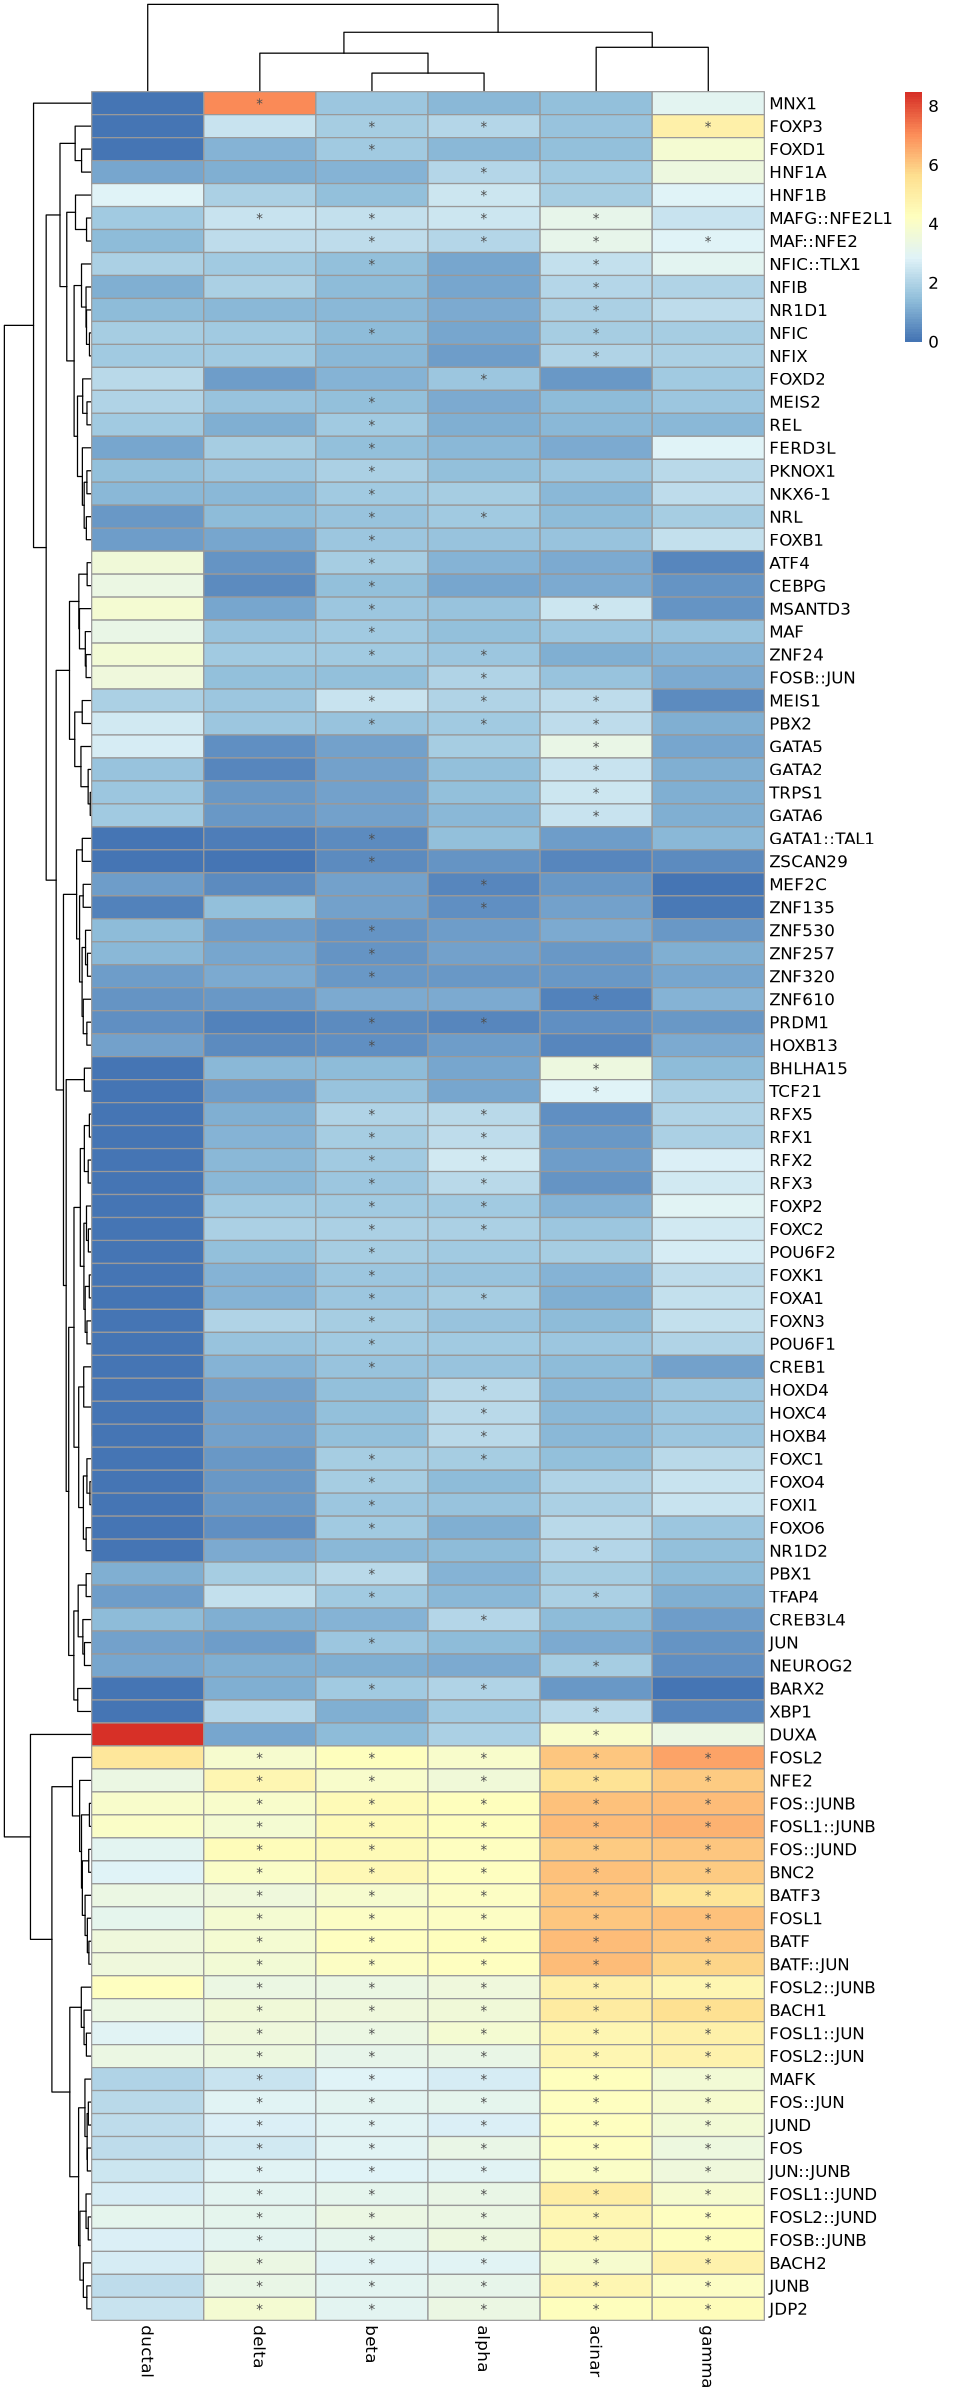

In [255]:
full.res <- read.table('/path/to/caQTL/stuff/motifs/240708_Fisher_ct_motif_enrichment_JASPAR.tsv',
                      header=T, sep='\t')
#full.res

heat_data <- select(full.res, estimate, motif, cell) %>%
    pivot_wider(values_from=estimate, names_from=cell) %>%
    tibble::column_to_rownames(var='motif') %>%
    as.matrix()

#head(heat_data)

heat_lab <- select(full.res, q.value, motif, cell) 
heat_lab$q.value <- heat_lab$q.value < 0.05
heat_lab$lab <- ''
heat_lab$lab[heat_lab$q.value] <- '*'
heat_lab <- select(heat_lab, -q.value)

heat_lab <- pivot_wider(heat_lab, values_from=lab, names_from=cell) %>%
    tibble::column_to_rownames(var='motif') %>%
    as.matrix()

#head(heat_lab)

options(repr.plot.width=8, repr.plot.height=20)
pheatmap(heat_data[unique(filter(full.res, q.value < 0.05)$motif),], scale='none',
        display_numbers =heat_lab[unique(filter(full.res, q.value < 0.05)$motif),])

In [212]:
heat_data <- select(full.res, estimate, motif, cell) %>%
    pivot_wider(values_from=estimate, names_from=cell) %>%
    tibble::column_to_rownames(var='motif') %>%
    as.matrix()

head(heat_data)

,beta,alpha,acinar,ductal,delta,gamma
FOS::JUND,4.420757,4.198283,5.972486,3.025758,4.339476,6.094861
BNC2,4.510413,4.234000,6.111039,2.832029,4.065606,5.957727
FOSL2,4.249562,3.935357,6.083076,5.289823,3.874927,6.641490
FOS::JUNB,4.462689,4.316644,6.126788,3.912057,3.949801,6.201865
FOSL1,4.115597,4.086358,6.109273,3.111783,3.790151,6.135659
BATF,4.183061,4.268944,6.256744,3.540105,3.808892,6.101886


In [214]:
sum(unique(filter(full.res, q.value < 0.05)$motif) %in% rownames(heat_data))
length(unique(filter(full.res, q.value < 0.05)$motif))

[1] 97

[1] 97

In [ ]:
[unique(filter(full.res, q.value < 0.05)$motif),]

In [210]:
unique(filter(full.res, q.value < 0.05)$motif)

[1] "FOS::JUND"    "BNC2"         "FOSL2"        "FOS::JUNB"    "FOSL1"       
 [6] "BATF"         "BATF::JUN"    "FOSL1::JUNB"  "NFE2"         "BACH1"       
[11] "BATF3"        "FOSL1::JUN"   "FOSL2::JUND"  "FOS::JUN"     "JUNB"        
[16] "FOSL2::JUN"   "JDP2"         "JUND"         "FOSL2::JUNB"  "BACH2"       
[21] "FOSB::JUNB"   "FOS"          "JUN::JUNB"    "FOSL1::JUND"  "MAFK"        
[26] "MAFG::NFE2L1" "MAF::NFE2"    "MEIS1"        "PBX1"         "FOXC2"       
[31] "ATF4"         "PKNOX1"       "FOXC1"        "PRDM1"        "TFAP4"       
[36] "ZNF24"        "RFX5"         "FOXP2"        "MAF"          "FOXO4"       
[41] "ZNF530"       "FOXP3"        "RFX1"         "FOXK1"        "FOXN3"       
[46] "MEIS2"        "RFX2"         "POU6F1"       "FOXO6"        "FOXA1"       
[51] "JUN"          "NRL"          "RFX3"         "CEBPG"        "FOXD1"       
[56] "POU6F2"       "MSANTD3"      "ZNF257"       "FOXB1"        "FERD3L"      
[61] "ZNF320"       "CREB1"        "HOXB13"       "BARX2"        "FOXI1"       
[66] "PBX2"         "GATA1::TAL1"  "NFIC"         "NFIC::TLX1"   "NKX6-1"      
[71] "REL"          "ZSCAN29"      "HNF1B"        "CREB3L4"      "HNF1A"       
[76] "MEF2C"        "ZNF135"       "FOXD2"        "FOSB::JUN"    "HOXC4"       
[81] "HOXB4"        "HOXD4"        "DUXA"         "NFIX"         "GATA5"       
[86] "BHLHA15"      "ZNF610"       "NR1D2"        "NFIB"         "GATA2"       
[91] "TRPS1"        "TCF21"        "GATA6"        "NEUROG2"      "XBP1"        
[96] "NR1D1"        "MNX1"

In [202]:
library(pheatmap)

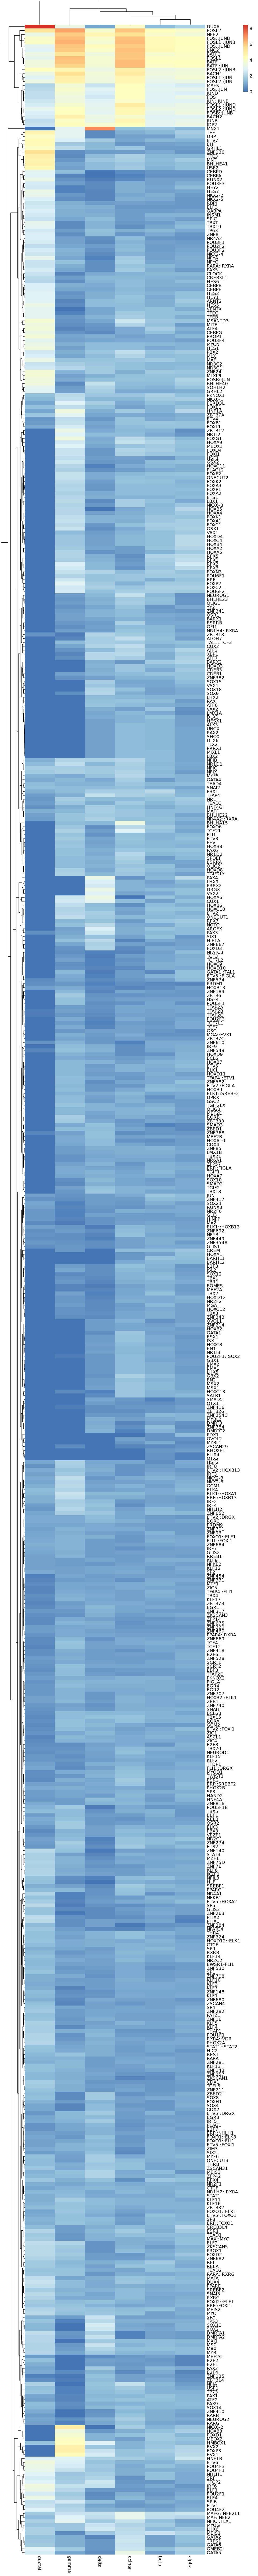

In [207]:
options(repr.plot.width=8, repr.plot.height=80)
pheatmap(select(full.res, estimate, motif, cell) %>%
    pivot_wider(values_from=estimate, names_from=cell) %>%
    tibble::column_to_rownames(var='motif') %>%
    as.matrix())

In [231]:
heat_lab <- select(full.res, q.value, motif, cell) 
heat_lab$q.value <- heat_lab$q.value < 0.05
heat_lab$lab <- ''
heat_lab$lab[heat_lab$q.value] <- '*'
heat_lab <- select(heat_lab, -q.value)

heat_lab <- pivot_wider(heat_lab, values_from=lab, names_from=cell) %>%
    tibble::column_to_rownames(var='motif') %>%
    as.matrix()

head(heat_lab)

,beta,alpha,acinar,ductal,delta,gamma
FOS::JUND,*,*,*,,*,*
BNC2,*,*,*,,*,*
FOSL2,*,*,*,,*,*
FOS::JUNB,*,*,*,,*,*
FOSL1,*,*,*,,*,*
BATF,*,*,*,,*,*


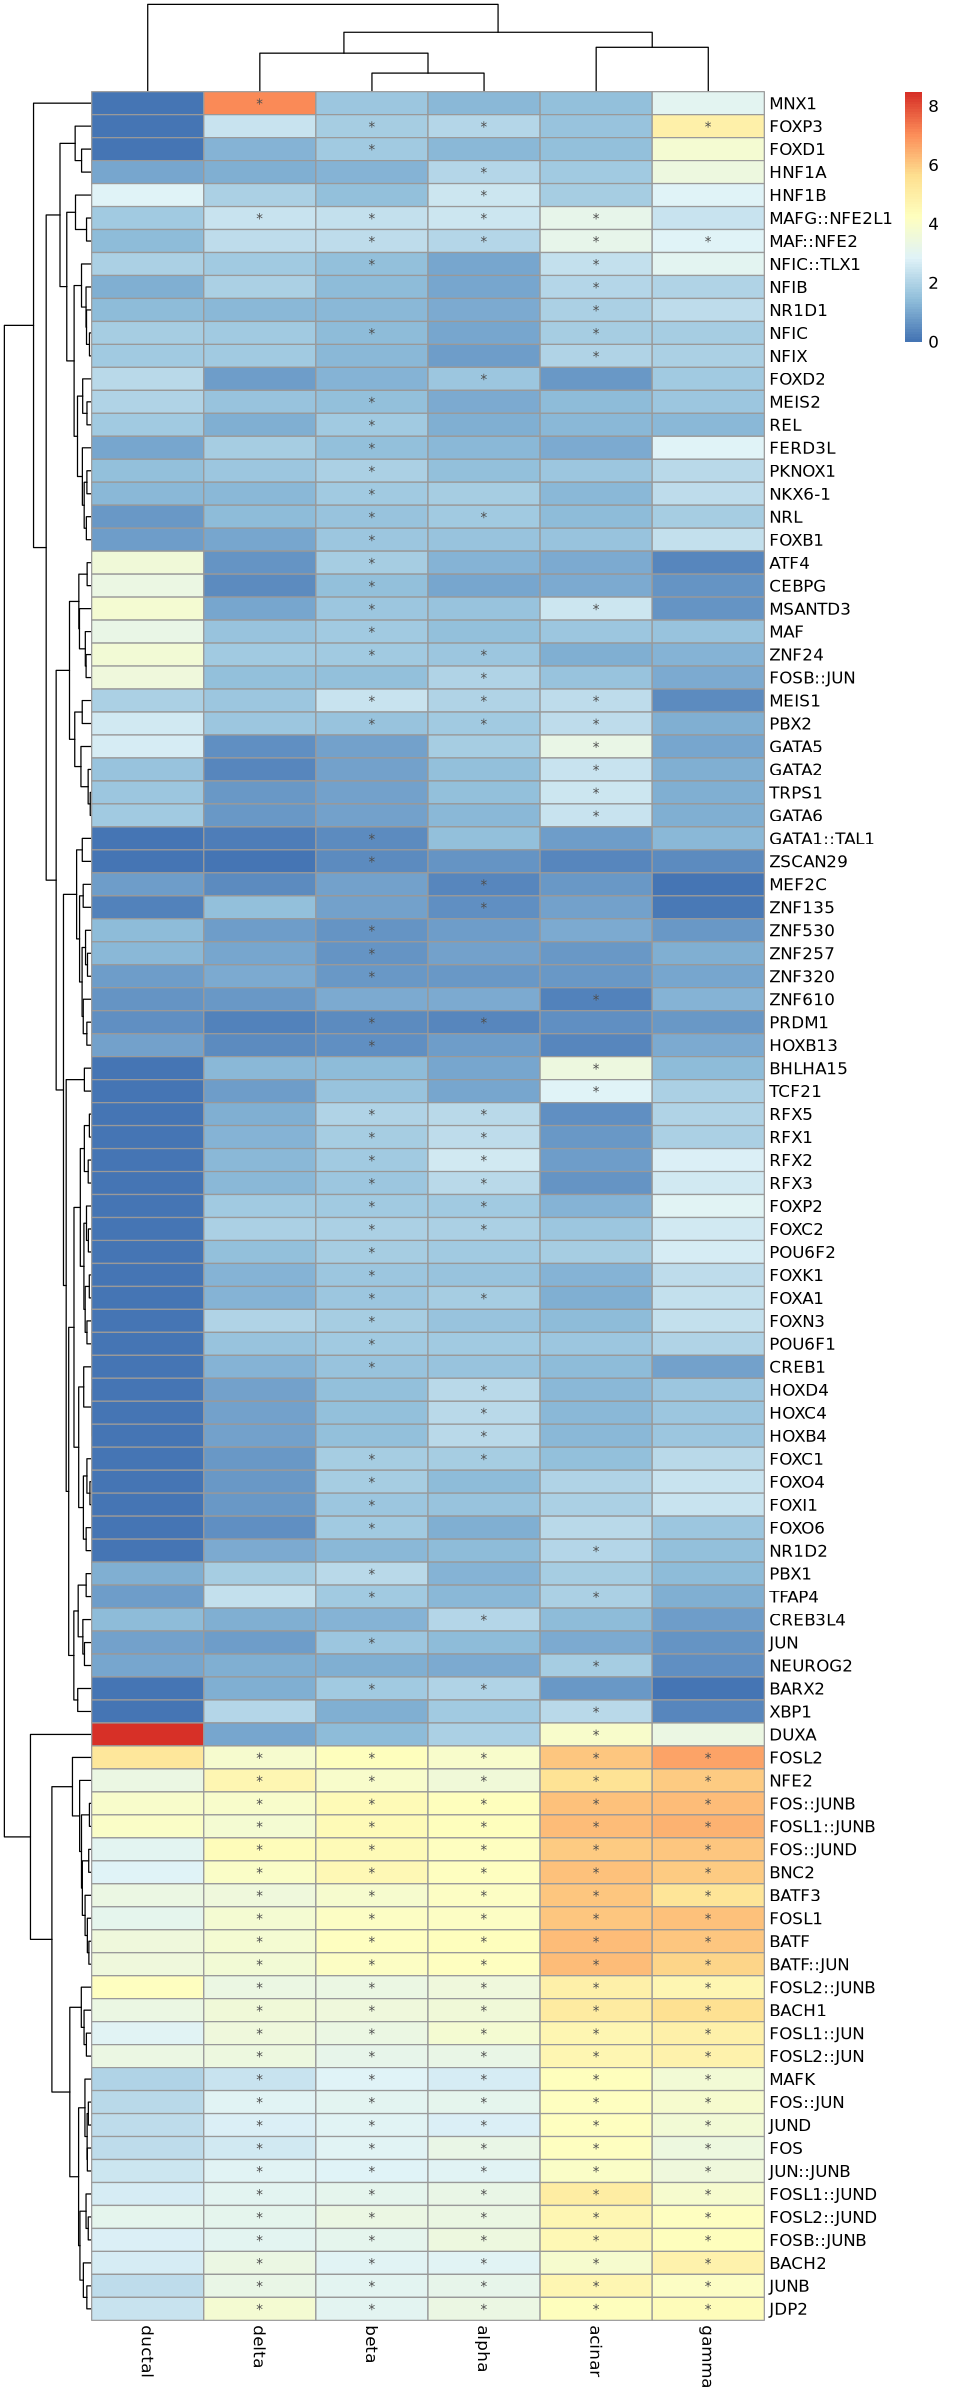

In [232]:
options(repr.plot.width=8, repr.plot.height=20)
pheatmap(heat_data[unique(filter(full.res, q.value < 0.05)$motif),], scale='none',
        display_numbers =heat_lab[unique(filter(full.res, q.value < 0.05)$motif),])